In [144]:
# Importing the necessary Libraries

import numpy as np
import pandas as pdi
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import sklearn
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import models, layers

Dataset: We managed to find a dataset on Kaggle which already divided the tumor images into four different categories, which are glioma tumor, meningioma tumor, pituitary tumor, and no tumor. Further, the images are already split in to Training and Testing Folders. 

Dataset Link: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

The first part of this project involves detecting the presence or absence of brain tumors if a tumor is present classify the tumor into one of the three categories mentioned above.

- Meningioma is the most common type of brain tumor.  Most  Meningiomas are classified as benign tumors meaning it is a mass of cells that grows slowly and remains localized (does not spread to other parts of the brain.)
- Gliomas are also common in adults and be either benign or malignant with malignant meaning that it is a mass of cells that grows uncontrollably and has the ability to spread to other nearby tissues in the brain. The further classification of gliomas depend on the specific types of glioma and it's aggressiveness which can range from Grade I - IV (grade IV being the most aggressive).
- Pituitary Tumors is the least common among the three and are typically classified as benign.

## 1. Loading the Dataset

In [89]:
# Loading the Training Dataset directory

# Define the path
train_dir = './Dataset/Training/'

# Creating a dictionary to associate the name of each class (tumor type - key) with the nnumber of images in the corresponding folder(value).

number_classes = {'no_tumor' : len(os.listdir('./Dataset/Training/no_tumor')),
                 'glioma_tumor' : len(os.listdir('./Dataset/Training/glioma_tumor')),
                 'meningioma_tumor' : len(os.listdir('./Dataset/Training/meningioma_tumor')),
                 'pituitary_tumor' : len(os.listdir('./Dataset/Training/pituitary_tumor'))}

In [90]:
print(number_classes)

{'no_tumor': 395, 'glioma_tumor': 826, 'meningioma_tumor': 822, 'pituitary_tumor': 827}


## 2. Data Exploration (Exploratory Analysis)

Text(0.5, 1.0, 'No. of Images for each Brain Tumor Type')

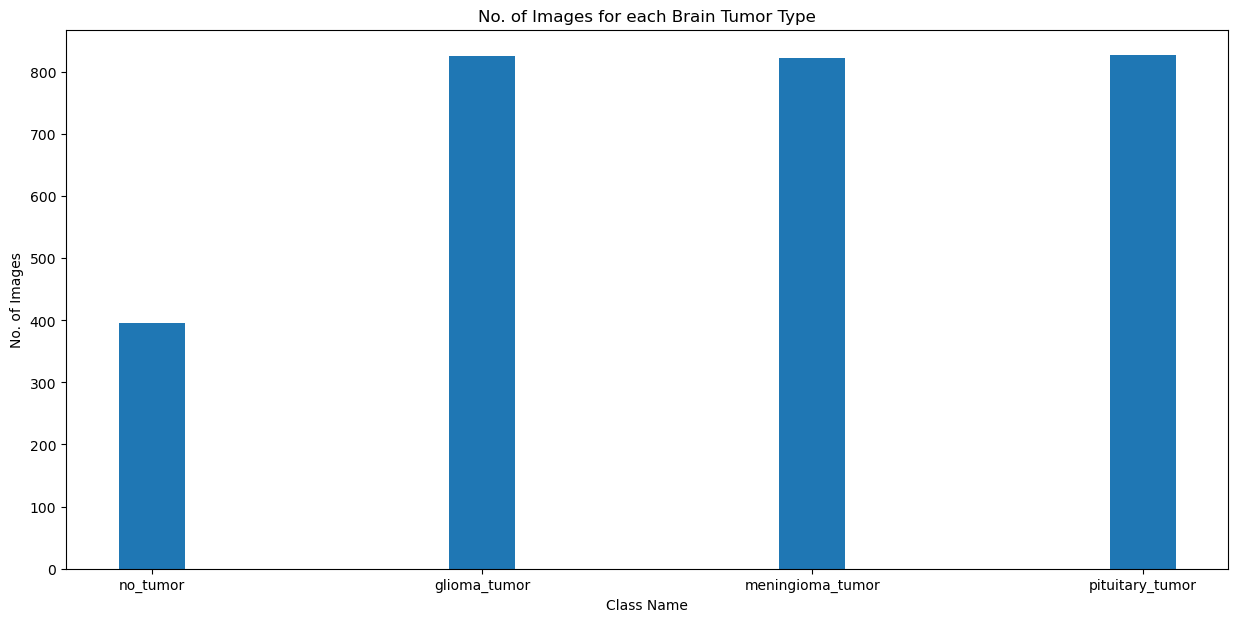

In [91]:
# Creating a class frequency bar-plot

plt.subplots(figsize=(15, 7))
plt.bar(number_classes.keys(), number_classes.values(), width = .2)
plt.xlabel('Class Name')
plt.ylabel('No. of Images')
plt.title('No. of Images for each Brain Tumor Type')

In [92]:
# Loading the images...

def get_images(base_dir, path, extension = ".jpg"):
    return [ fn for fn in os.listdir(f'{base_dir}{path}') if fn.endswith(extension)]

no_tumor_images = get_images(train_dir, "no_tumor")
glioma_images = get_images(train_dir, "glioma_tumor")
meningioma_images = get_images(train_dir, "meningioma_tumor")
pituitary_images = get_images(train_dir, "pituitary_tumor")

In [93]:
# Randomly selecting 5 images from each class

def select_random_image(image):
    return np.random.choice(image, 5, replace = False)

select_no_tumor = select_random_image(no_tumor_images)
select_glioma = select_random_image(glioma_images)
select_meningioma = select_random_image(meningioma_images)
select_pituitary = select_random_image(pituitary_images)

In [94]:
select_no_tumor

array(['image(297).jpg', 'image(298).jpg', 'image(306).jpg',
       'image(2).jpg', 'image(128).jpg'], dtype='<U14')

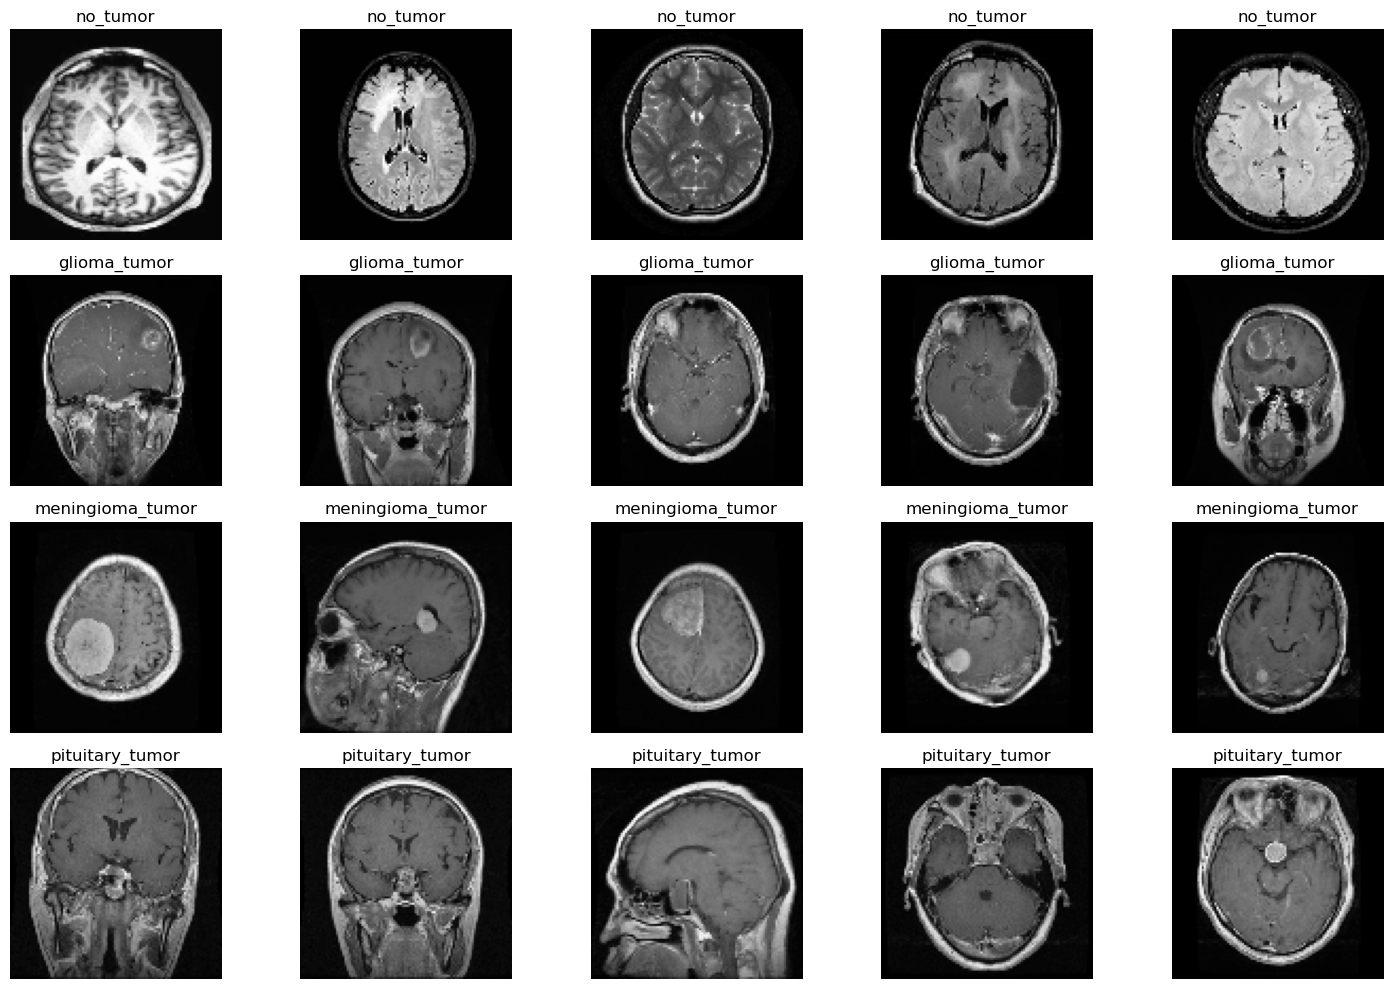

In [95]:
# Plotting a matrix of images selected

# Function to plot images
def plot_images(image_array, class_name, start_index, rows, cols):
    for i in range(len(image_array)):
        fp = f'{train_dir}{class_name}/{image_array[i]}'
        ax = fig.add_subplot(rows, cols, start_index + i)
        fn = load_img(fp, target_size=(100, 100), color_mode='grayscale')
        plt.imshow(fn, cmap="Greys_r")
        plt.title(class_name)
        plt.axis('off')

# Create a figure
fig = plt.figure(figsize=(15, 10))

# Plotting no tumor images
plot_images(select_no_tumor, "no_tumor", 1, 4, 5)

# Plotting glioma images
plot_images(select_glioma, "glioma_tumor", 6, 4, 5)

# Plotting meningioma images
plot_images(select_meningioma, "meningioma_tumor", 11, 4, 5)

# Plotting pituitary images
plot_images(select_pituitary, "pituitary_tumor", 16, 4, 5)

plt.tight_layout()
plt.show()


In [96]:
# Flattening the images into a 1D vector and creating a 2D array of the entire images, with each row of the 2D
# array representing an image.

def img2mat(path, filename, size=(64,64)):
    for fn in filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        
        # Convert the image into a matrix
        img_vector = image.img_to_array(current_image)
        # Turn current_image into a vector
        img_vector = [img_vector.ravel()]
        try:
            # Concatenate different images
            full_mat = np.concatenate((full_mat, img_vector))
        except:
            # If full matrix is not defined during the first ireration, create one.
            full_mat = img_vector
    return full_mat

# Run the function on our folders

no_tumor_images = img2mat(f'{train_dir}no_tumor/', no_tumor_images)
glioma_images = img2mat(f'{train_dir}glioma_tumor/', glioma_images)
meningioma_images = img2mat(f'{train_dir}meningioma_tumor/', meningioma_images)
pituitary_images = img2mat(f'{train_dir}pituitary_tumor/', pituitary_images)

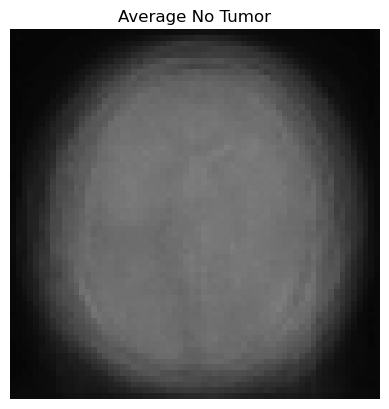

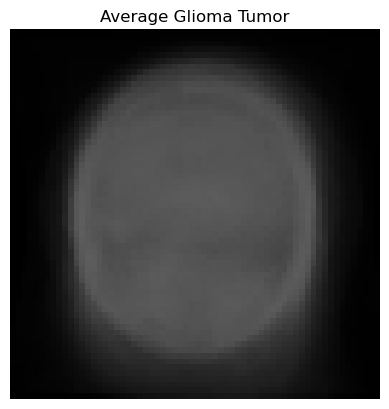

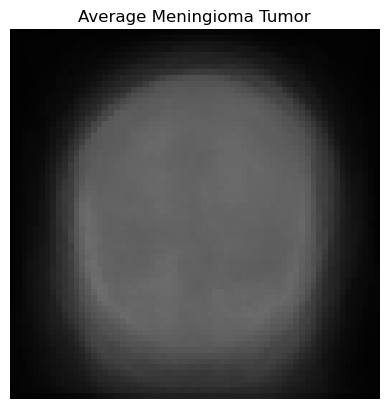

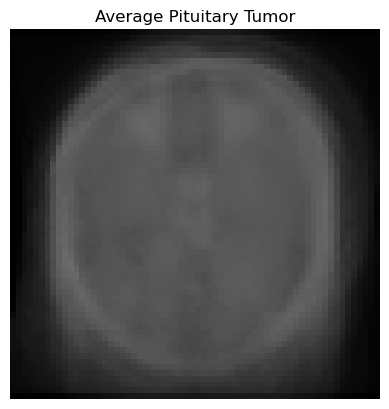

In [97]:
# Creating a function that will take the average for each category. 

def mean_of_images(full_mat, title, size = (64, 64)):
    # Calculate the average
    avg_image = np.mean(full_mat, axis = 0)
    # Reshape it back into a matrix
    avg_image = avg_image.reshape(size)
    plt.imshow(avg_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return avg_image

# Running the function on our 4 matrices

no_tumor_mean = mean_of_images(no_tumor_images, 'No Tumor')
glioma_mean = mean_of_images(glioma_images, 'Glioma Tumor')
meningioma_mean = mean_of_images(meningioma_images, 'Meningioma Tumor')
pituitary_mean = mean_of_images(pituitary_images, 'Pituitary Tumor')

This is essentially the average image for each of the 4 categories in the dataset.
Now,  I will compare the average of no_tumor images with each of the other three categories and plot an image for the same...
this helps visualize and analyze the typical characteristics of each tumor type.

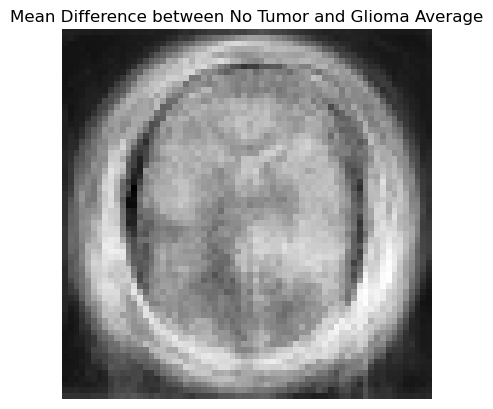

In [101]:
# 1. Glioma Tumor VS No Tumor
difference_mean = no_tumor_mean - glioma_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Glioma Average')
plt.axis('off')
plt.show()

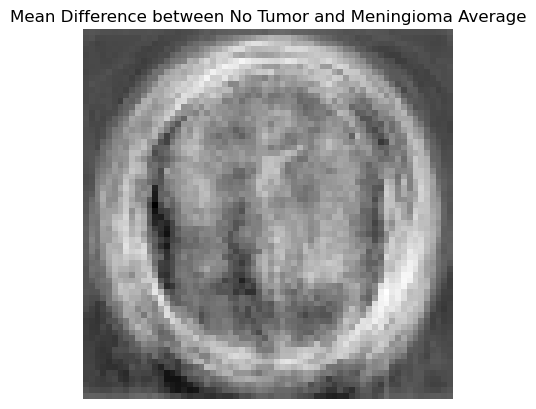

In [102]:
# 2. Meningioma Tumor VS No Tumor

difference_mean = no_tumor_mean - meningioma_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Meningioma Average')
plt.axis('off')
plt.show()

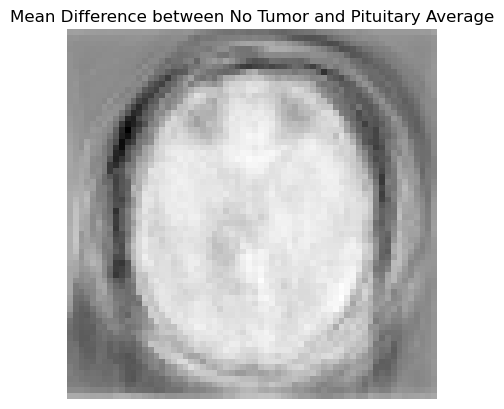

In [103]:
# 3. Pituitary Tumor vs No Tumor

difference_mean = no_tumor_mean - pituitary_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Pituitary Average')
plt.axis('off')
plt.show()

## 3. Data Preparation

In [104]:
# Train and Test Sets : I have created a function here which will generate the training and testing sets.

def train_test_set(size, labels):
    X_train, X_test, y_train, y_test = [], [], [], []
    
    # Training Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Training/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_train set
            X_train.append(image)
            # Append the corresponding label to the y_train set
            y_train.append(label)
            
      # Testing Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Testing/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_test set
            X_test.append(image)
            # Append the corresponding label to the y_test set
            y_test.append(label)
    return  X_train, X_test, y_train, y_test

In [105]:
# Image folder labels

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Calling the function..

X_train, X_test, y_train, y_test = train_test_set(150, labels)

100%|██████████| 74/74 [00:01<00:00, 55.93it/s]


In [106]:
# Converting X_train, X_test, y_train, y_test into numpy arrays

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [107]:
# Let's check the shapes now...

print('Shapes of the sets')
print(f'{"-"*30}\n')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes of the sets
------------------------------

X_train: (2870, 150, 150, 3)
y_train: (2870,)
X_test: (308, 150, 150, 3)
y_test: (308,)


The sets have 3 channels which indicates that they are in RGB format.

## 4. Shuffling and the Encoding the Training and Testing Sets

In [110]:
# Shuffling the dataset to randomize the order

X_train, y_train = shuffle(X_train, y_train, random_state = 0)
X_test, y_test = shuffle(X_test, y_test, random_state = 0)

In [113]:
# Encoding...

# Label encoding...

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [118]:
# One hot Encoding..

y_train_one_hot_encoded = tf.keras.utils.to_categorical(y_train)

y_test_one_hot_encoded = tf.keras.utils.to_categorical(y_test)

## 5. CNN Models...

In [129]:
# Function to generate line plots based on the history of the model to evaluate it.

def generate_plot(hist):
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.plot(hist.history['accuracy'], label='Accuracy')
    plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc = 'upper right')
    plt.show()

In [153]:
def model_1(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
    # Define the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape = shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels), activation = 'softmax'))
    print('CNN Layer Model Summary \n')
    print(model.summary())
                           
    # Compile the model
    model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs = 15, validation_data = (X_test, y_test))
    
    # Plotting the train and validation accuracy line plots
    generate_plot(history)
    
    print()
    print()
    print()
    
    # Accuracy
    print('\n Model Accuracy and Loss \n')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Loss: {test_loss}')
    
    print()
    print()
    print()
    
    # Prediction
    pred = np.argmax(model.predict(X_test), axis = 1)
    
    # Classification report
    print('\n Classification report \n')
    report = classification_report(y_test, pred)
    print(report)
    
    print()
    print()
    print()
    
    # Heatmap
    pred = np.argmax(model.predict(X_test), axis = 1)
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.heatmap(confusion_matrix(y_test, pred), xticklabels = labels, yticklabels = labels, annot = True, cmap = 'viridis', fmt = 'g')
    plt.title('Heatmap', y=1.05)
    

In [154]:
shape = X_train.shape[1:]
shape

(150, 150, 3)

CNN Layer Model Summary 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin 

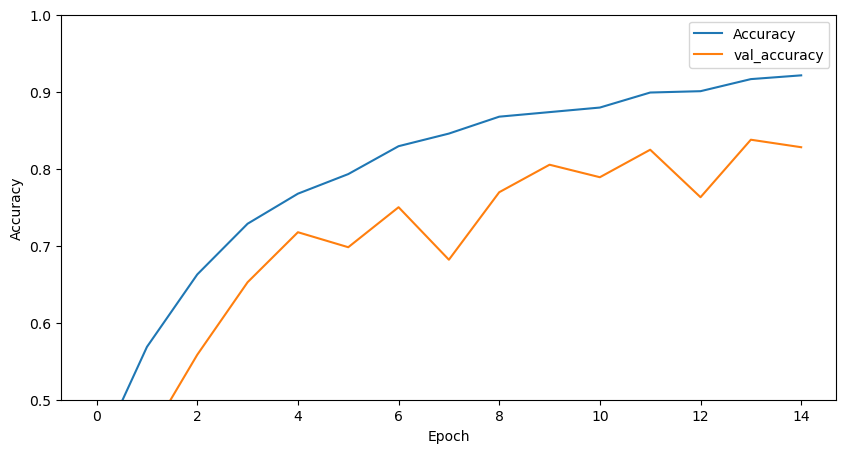





 Model Accuracy and Loss 

10/10 [==============================] - 1s 63ms/step - loss: 1.2856 - accuracy: 0.8279
Test Accuracy: 0.8279221057891846
Test Loss: 1.2856426239013672



10/10 [==============================] - 1s 65ms/step

 Classification report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.84      0.83      0.84       115
           2       0.80      1.00      0.89       105
           3       0.87      0.73      0.79        74

    accuracy                           0.83       308
   macro avg       0.63      0.64      0.63       308
weighted avg       0.79      0.83      0.81       308




 1/10 [==>...........................] - ETA: 1s

C:\Users\rachitsainii\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachitsainii\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachitsainii\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

10/10 [==============================] - 1s 69ms/step


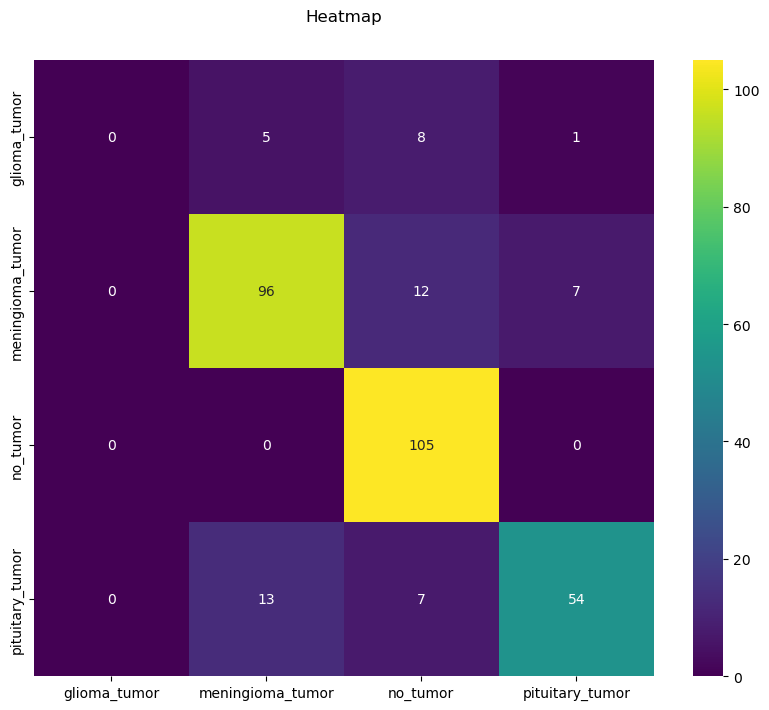

In [155]:
model_1(shape, labels, X_train, X_test, y_train, y_test, loss = 'sparse_categorical_crossentropy')